# Powersensor 基础教程 part2

这部分教程主要包含如何使用opencv库对摄像头采集的图像进行预处理以及一些简单的图像特征提取

引用需要的库

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import PowerSensor as ps

初始化摄像头和串口模块的操作对象

In [2]:
# 这个对象用于操作摄像头
cam1 = ps.ImageSensor()
# 这个对象用于操作串口
s1 = ps.UsartPort()

# 图像的特征2，梯度特征与常见边缘算子

图像的梯度可以用一阶导数和二阶偏导数来求解，但是图像以矩阵的形式存储的，不能像数学理论中对直线或者曲线求导一样，对一幅图像的求导相当于对一个平面、曲面求导。对图像的操作，一般采用边缘算子核对原图像进行卷积运算，从而达到突出边缘的效果。

常见的用于计算图像梯度的边缘算子有

1. Sobel
1. Lapacian
1. Roberts 
1. Canny

## Sobel 算子

Sobel算子根据像素点上下、左右邻点灰度加权差，在边缘处达到极值这一现象检测边缘。对噪声具有平滑作用，提供较为精确的边缘方向信息，边缘定位精度不够高。当对精度要求不是很高时，是一种较为常用的边缘检测方法。

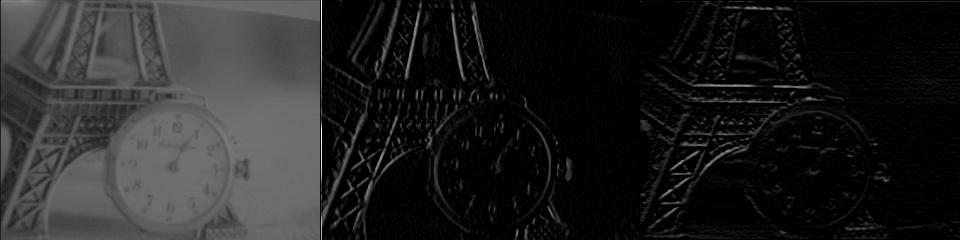

In [16]:
img = None
for i in range(100):
    
    clear_output(wait=True)    # 清除图片，在同一位置显示，不使用会打印多张图片
    
    imgMat = cam1.read_img_ori()       # 读入图像
    
    # 缩小图像为320x240尺寸
    origin = cv2.resize(imgMat, (320,240))  
    rows,cols,_ = origin.shape
    
    # ---------------------  图像处理开始  ----------------------------------------
    start = time.time()        # 记录开始时间
    
    # 把图片转换成灰度图
    img_gray = cv2.cvtColor(origin, cv2.COLOR_BGR2GRAY)
    img_sobelx = cv2.Sobel(img_gray, cv2.CV_16S, 1, 0, ksize=3) # x 方向， ksiz是卷积核的大小, 换成16位是因为算子过程可以使原图像的值溢出。
    img_sobely = cv2.Sobel(img_gray, cv2.CV_16S, 0, 1, ksize=3) # y 方向
    
    end = time.time()        # 记录结束时间
    # ---------------------  图像处理结束  ----------------------------------------
    
#     # 把图像拼接在一起显示
    img_combine = np.hstack([img_gray, img_sobelx, img_sobely])

    ps.CommonFunction.show_img_jupyter(img_combine)
    
    
#     print(end - start)
    time.sleep(0.1)

可以发现x方向的sobel对垂直方向的纹理更敏感（如塔的轮廓），而y方向的sobel对水平方向的纹理更敏感（如钟上的英文）。

## Laplacian算子

Laplace函数实现的方法是先用Sobel 算子计算二阶x和y导数，再求和。因此Laplacian算子对横竖两个方向的纹理都很敏感。

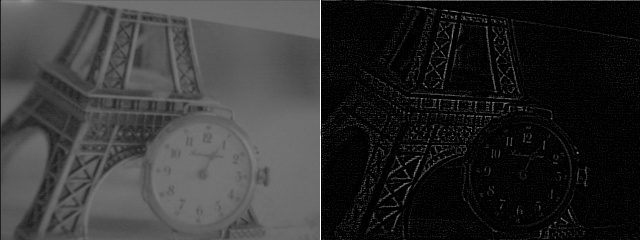

In [17]:
img = None
for i in range(100):
    
    clear_output(wait=True)    # 清除图片，在同一位置显示，不使用会打印多张图片
    
    imgMat = cam1.read_img_ori()       # 读入图像
    
    # 缩小图像为320x240尺寸
    origin = cv2.resize(imgMat, (320,240))  
    rows,cols,_ = origin.shape
    
    # ---------------------  图像处理开始  ----------------------------------------
    start = time.time()        # 记录开始时间
    
    # 把图片转换成灰度图
    img_gray = cv2.cvtColor(origin, cv2.COLOR_BGR2GRAY)
    img_lap = cv2.Laplacian(img_gray, cv2.CV_16S,  ksize=3) # ksiz是卷积核的大小, 换成16位是因为算子过程可以使原图像的值溢出。
    
    end = time.time()        # 记录结束时间
    # ---------------------  图像处理结束  ----------------------------------------
    
#     # 把图像拼接在一起显示
    img_combine = np.hstack([img_gray, img_lap])

    ps.CommonFunction.show_img_jupyter(img_combine)
    
    
#     print(end - start)
    time.sleep(0.1)

## Roberts算子

Roberts边缘算子（交叉梯度算子）是一个2x2的模板，这个算子在检测边缘效果非常好，但是它对噪声相当敏感，适用于边缘明显且噪声较少的图像分割。

Reberts算子opencv没有提供直接的函数，不过可以用它提供的卷积滤波函数自行构建。

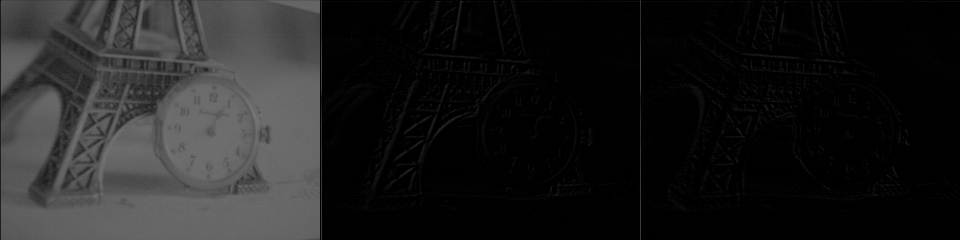

In [18]:
img = None
for i in range(100):
    
    clear_output(wait=True)    # 清除图片，在同一位置显示，不使用会打印多张图片
    
    imgMat = cam1.read_img_ori()       # 读入图像
    
    # 缩小图像为320x240尺寸
    origin = cv2.resize(imgMat, (320,240))  
    rows,cols,_ = origin.shape
    
    # ---------------------  图像处理开始  ----------------------------------------
    start = time.time()        # 记录开始时间
    
    # 把图片转换成灰度图
    img_gray = cv2.cvtColor(origin, cv2.COLOR_BGR2GRAY)
    kernelx = np.array([[-1,0],[0,1]], dtype=int)
    kernely = np.array([[0,-1],[1,0]], dtype=int)
    img_robertsX = cv2.filter2D(img_gray, cv2.CV_16S, kernelx)
    img_robertsY = cv2.filter2D(img_gray, cv2.CV_16S, kernely)
    
    end = time.time()        # 记录结束时间
    # ---------------------  图像处理结束  ----------------------------------------
    
#     # 把图像拼接在一起显示
    img_combine = np.hstack([img_gray, img_robertsX, img_robertsY])

    ps.CommonFunction.show_img_jupyter(img_combine)
    
    
#     print(end - start)
    time.sleep(0.1)

## Canny 算子

Canny算子是Sobel算子的拓展版，它包含以下功能。

- 噪音去除

由于边缘检测很容易受到噪音影响，所以第一步是使用5x5的高斯滤波器去除噪音。

- 计算图像梯度

对平滑后的图像使用Sobel计算水平方向和竖直方向的一阶导数（图像梯度）（Gx和Gy）。根据得到的这两幅梯度图找到边界的梯度和方向。

- 滞后阈值

Canny算子有两个阀值参数：minVal和maxVal。当图像的灰度梯度高于maxVal时被认为是真的边界，那些低于minVal的边界会被抛弃。如果介于两者之间的话，就要看这个点是否与某个被确定为真正边界点相连，如果是，就认为它也是边界点，如果不是就抛弃。

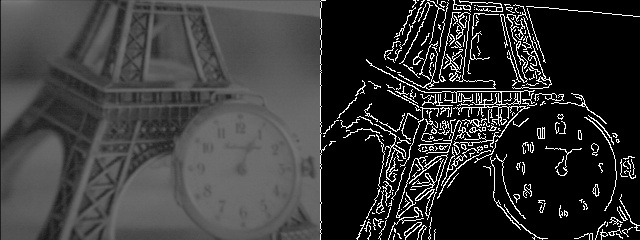

In [25]:
img = None
for i in range(100):
    
    clear_output(wait=True)    # 清除图片，在同一位置显示，不使用会打印多张图片
    
    imgMat = cam1.read_img_ori()       # 读入图像
    
    # 缩小图像为320x240尺寸
    origin = cv2.resize(imgMat, (320,240))  
    rows,cols,_ = origin.shape
    
    # ---------------------  图像处理开始  ----------------------------------------
    start = time.time()        # 记录开始时间
    
    # 把图片转换成灰度图
    img_gray = cv2.cvtColor(origin, cv2.COLOR_BGR2GRAY)
    img_canny = cv2.Canny(img_gray, 30, 60, apertureSize=3)  # apertureSize是sobel算子的卷积核大小
    
    end = time.time()        # 记录结束时间
    # ---------------------  图像处理结束  ----------------------------------------
    
#     # 把图像拼接在一起显示
    img_combine = np.hstack([img_gray, img_canny])

    ps.CommonFunction.show_img_jupyter(img_combine)
    
    
#     print(end - start)
    time.sleep(0.1)

# 图像的特征3，频域特征

## 离散傅里叶变换

傅里叶过程是可逆的，图像经过傅里叶变换、逆变换后，能够恢复到原始图像。可以在频域对图像进行处理，在频域的处理会反映到逆变换的图像上。

使用numpy实现傅里叶变换函数，主要有如下函数。

1.傅里叶变换与其逆变换
  numpy.fft.fft2 <--> numpy.fft.fft2

2.将傅里叶变换移到中心
  np.fft.fftshift  <--> numpy.fft.ifftshift
  
3.将复数变为实数
  np.abs(逆傅里叶变换后的结果)

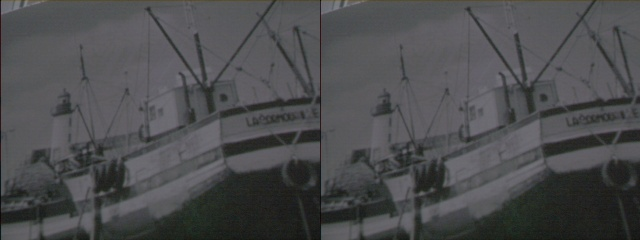

0.507224082947


In [6]:
for i in range(20):
    
    clear_output(wait=True)    # 清除图片，在同一位置显示，不使用会打印多张图片
    imgMat = cam1.read_img_ori()       # 读入图像
    # 缩小图像为320x240尺寸
    origin = cv2.resize(imgMat, (320,240))
    
    # ---------------------  图像处理开始  ----------------------------------------
    start = time.time()        # 记录开始时间
    
    f = np.fft.fft2(origin)  # 傅里叶变换
    fImg = abs(f)
    
    fshift = np.fft.fftshift(f)  # 移动
    ishift = np.fft.ifftshift(fshift) # 移动回去
    iimg = np.fft.ifft2(ishift)  # 逆变换
    iimg = np.abs(iimg)  # 取绝对值变为实数
        
    end = time.time()        # 记录结束时间
    # ---------------------  图像处理结束  ----------------------------------------       
    
    # 把图像拼接在一起显示
    img_combine = np.hstack([origin, iimg])
    ps.CommonFunction.show_img_jupyter(img_combine)# 打印用于差分的两张图片
    
    print(end - start)
    time.sleep(0.1)

## 通过频域进行高通滤波

低频对应图像中变化缓慢的灰度分量。例如，在一幅大草原的图像中，低频对应着广袤的颜色趋于一致的草原。衰减高频而通过低频称为低通滤波器，可模糊一幅图像。

高频对应图像内变化越来越快的灰度分量，是由灰度的尖锐过度造成的。例如，在一幅大草原的图像中，其中狮子的边缘信息。衰减低频而通过高频称为高通滤波器，将增强尖锐的细节，但是会导致图像的对比度下降。

滤波是指接收(通过)或者拒绝一定频率的分量。其中通过低频的滤波器称为低通滤波器，通过高频的滤波器称为高通滤波器。

频域滤波是通过傅里叶变换到频域，通过滤波达到图像增强、图像去噪、边缘检测、特征提取、压缩、加密等特殊目的，最后可以通过逆傅里叶返回到图像域。

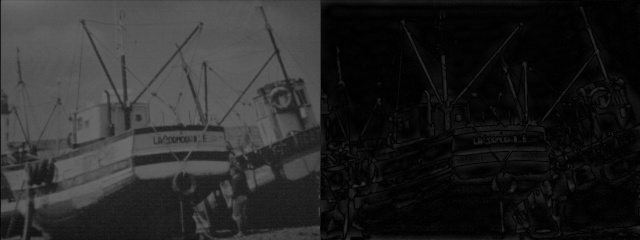

0.165810108185


In [8]:
for i in range(100):
    
    clear_output(wait=True)    # 清除图片，在同一位置显示，不使用会打印多张图片
    imgMat = cam1.read_img_ori()       # 读入图像
    
    # 缩小图像为320x240尺寸
    origin = cv2.resize(imgMat, (320,240))
    origin = cv2.cvtColor(origin, cv2.COLOR_BGR2GRAY)
    
    # ---------------------  图像处理开始  ----------------------------------------
    start = time.time()        # 记录开始时间
    
    # fft
    f = np.fft.fft2(origin)      # 傅里叶变换
    fshift = np.fft.fftshift(f)  # 低频点移动到中心
    
    # 去掉低频，高通滤波器
    rows,cols = origin.shape
    crow,ccol = int(rows/2),int(cols/2) # 中心
    fshift[crow-10:crow+10,ccol-10:ccol+10] = 0
    
    # ifft
    ishift = np.fft.ifftshift(fshift) # 移动回去
    iimg = np.fft.ifft2(ishift)  # 逆变换
    iimg = np.abs(iimg)  # 取绝对值变为实数
        
    end = time.time()        # 记录结束时间
    # ---------------------  图像处理结束  ----------------------------------------       
    
    # 把图像拼接在一起显示
    img_combine = np.hstack([origin, iimg])
    ps.CommonFunction.show_img_jupyter(img_combine)# 打印用于差分的两张图片
    
    print(end - start)
    time.sleep(0.1)

## 通过频域进行低通滤波

方法与上文高通滤波器类似。

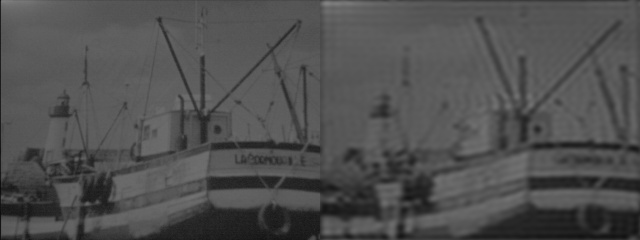

0.175346136093


In [9]:
for i in range(100):
    
    clear_output(wait=True)    # 清除图片，在同一位置显示，不使用会打印多张图片
    imgMat = cam1.read_img_ori()       # 读入图像
    
    # 缩小图像为320x240尺寸
    origin = cv2.resize(imgMat, (320,240))
    origin = cv2.cvtColor(origin, cv2.COLOR_BGR2GRAY)
    
    # ---------------------  图像处理开始  ----------------------------------------
    start = time.time()        # 记录开始时间
    
    # fft
    f = np.fft.fft2(origin)      # 傅里叶变换
    fshift = np.fft.fftshift(f)  # 低频点移动到中心
    
    # 构造掩模，去掉高频，低通滤波器
    rows,cols = origin.shape
    crow,ccol = int(rows/2),int(cols/2) # 中心
    mask = np.zeros((rows,cols),np.uint8)
    mask[crow-30:crow+30,ccol-30:ccol+30] = 1
    fshift = fshift*mask
    
    # ifft
    ishift = np.fft.ifftshift(fshift) # 移动回去
    iimg = np.fft.ifft2(ishift)  # 逆变换
    iimg = np.abs(iimg)  # 取绝对值变为实数
        
    end = time.time()        # 记录结束时间
    # ---------------------  图像处理结束  ----------------------------------------       
    
    # 把图像拼接在一起显示
    img_combine = np.hstack([origin, iimg])
    ps.CommonFunction.show_img_jupyter(img_combine)# 打印用于差分的两张图片
    
    print(end - start)
    time.sleep(0.1)

# 图像的轮廓提取


轮廓检测也是图像处理中经常用到的一个功能，opencv提供了一系列函数来辅助完成这一过程。
OpenCV-Python接口中使用cv2.findContours()函数来查找检测物体的轮廓。

1. 全局二值化

1. 局部自适应二值化

## 全局阈值二值化

全局阈值就是一幅图像包括目标物体、背景还有噪声，要想从多值的数字图像中直接提取出目标物体；常用的方法就是设定一个阈值T，用T将图像的数据分成两部分：大于T的像素群和小于T的像素群。这是研究灰度变换的最特殊的方法，称为图像的二值化（Binarization）。

opencv提供全局阈值的函数：cv2.threshold()

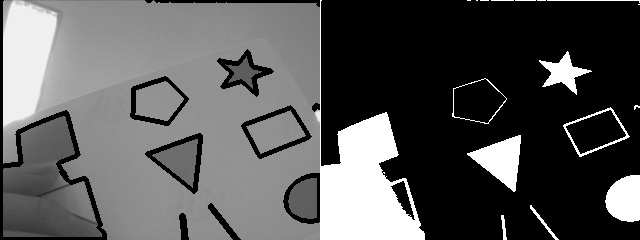

0.00786995887756


In [21]:
for i in range(100):
    
    clear_output(wait=True)    # 清除图片，在同一位置显示，不使用会打印多张图片
    imgMat = cam1.read_img_ori()       # 读入图像
    
    # 缩小图像为320x240尺寸
    origin = cv2.resize(imgMat, (320,240))
    
    # ---------------------  图像处理开始  ----------------------------------------
    start = time.time()        # 记录开始时间
    
    img_gray = cv2.cvtColor(origin, cv2.COLOR_BGR2GRAY) # 转成灰度图
    ret,img_binary = cv2.threshold(img_gray, 120, 255, cv2.THRESH_BINARY_INV) # 全局二值化
    thresh, contours, hierarchy = cv2.findContours(img_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # 查找轮廓
    cv2.drawContours(img_gray, contours, -1, 0, 3) # 把轮廓画在灰度图上
    
        
    end = time.time()        # 记录结束时间
    # ---------------------  图像处理结束  ----------------------------------------       
    
    # 把图像拼接在一起显示
    img_combine = np.hstack([img_gray, img_binary])
    ps.CommonFunction.show_img_jupyter(img_combine)# 打印用于差分的两张图片
    
    print(end - start)
    time.sleep(0.1)

## 局部自适应阈值化
局部阈值就是当同一幅图像上的不同部分的具有不同亮度时。这种情况下我们需要采用自适应阈值。此时的阈值是根据图像上的每一个小区域计算与其对应的阈值。因此在同一幅图像上的不同区域采用的是不同的阈值，从而使我们能在亮度不同的情况下得到更好的结果。提供全局阈值的函数：
```python
cv2.adaptiveThreshold(
    img, # 输入图像
    max_value, #像素的最大值，255
    adpative_method, #自适应方法有CV.ADAPTIVE_THRESH_MEAN_C 和 CV.ADAPTIVE_THRESH_GAUSSIAN_C
    threshold_type, # 二值化是否取反，CV_THRESH_BINARY 和 CV_THRESH_BINARY_INV
    block_size, # 局部大小，3，5，7...
    param1, # 偏置参数，可以看作阈值
)
```

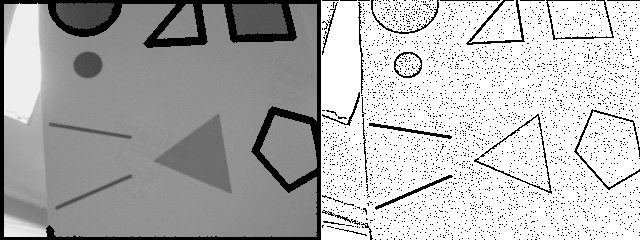

0.0115361213684


In [35]:
for i in range(100):
    
    clear_output(wait=True)    # 清除图片，在同一位置显示，不使用会打印多张图片
    imgMat = cam1.read_img_ori()       # 读入图像
    
    # 缩小图像为320x240尺寸
    origin = cv2.resize(imgMat, (320,240))
    
    # ---------------------  图像处理开始  ----------------------------------------
    start = time.time()        # 记录开始时间
    
    img_gray = cv2.cvtColor(origin, cv2.COLOR_BGR2GRAY) # 转成灰度图
    img_binary = cv2.adaptiveThreshold(img_gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,3,2) # 全局二值化, 
    thresh, contours, hierarchy = cv2.findContours(img_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # 查找轮廓
    cv2.drawContours(img_gray, contours, -1, 0, 3) # 把轮廓画在灰度图上
    
        
    end = time.time()        # 记录结束时间
    # ---------------------  图像处理结束  ----------------------------------------       
    
    # 把图像拼接在一起显示
    img_combine = np.hstack([img_gray, img_binary])
    ps.CommonFunction.show_img_jupyter(img_combine)# 打印用于差分的两张图片
    
    print(end - start)
    time.sleep(0.1)

# 常见几何图形检测

1. 直线检测
2. 椭圆检测
3. 通用轮廓检测并框出

## 直线检测

本教程使用霍夫变换来完成直线检测。

![linecheck](./img/linecheck.png)

```python
lines = cv2.HoughLinesP(
    edges,  # 输入的图像
    1, # rho的精度
    np.pi/180, # theta的精度
    100, #阈值，累加器的长度高于阈值才是直线
    minLineLength, # 直线的最小长度
    maxLineGap # 两个线段被识别成一个直线的最小距离)
```


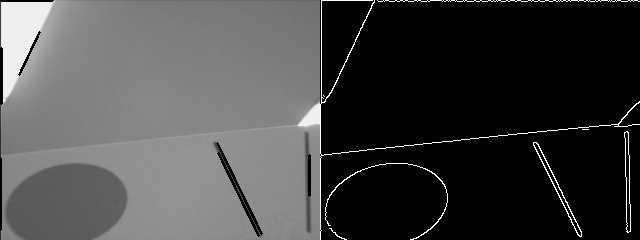

0.0245788097382


In [68]:
for i in range(100):
    
    clear_output(wait=True)    # 清除图片，在同一位置显示，不使用会打印多张图片
    imgMat = cam1.read_img_ori()       # 读入图像
    
    # 缩小图像为320x240尺寸
    origin = cv2.resize(imgMat, (320,240))
    
    # ---------------------  图像处理开始  ----------------------------------------
    start = time.time()        # 记录开始时间
    
    img_gray = cv2.cvtColor(origin, cv2.COLOR_BGR2GRAY)
    img_canny = cv2.Canny(img_gray, 30, 60, apertureSize=3)  # apertureSize是sobel算子的卷积核大小
    
    lines = cv2.HoughLinesP(img_canny, 1, np.pi/180, 5, 10, 40)
    if lines is None:
        pass
    else:
        for i in range(len(lines)):
            for x1,y1,x2,y2 in lines[i]:
                cv2.line(img_gray, (x1,y1), (x2,y2),(0), 2)
    
        
    end = time.time()        # 记录结束时间
    # ---------------------  图像处理结束  ----------------------------------------       
    
    # 把图像拼接在一起显示
    img_combine = np.hstack([img_gray, img_canny])
    ps.CommonFunction.show_img_jupyter(img_combine)# 打印用于差分的两张图片
    
    print(end - start)
    time.sleep(0.1)

## 圆检测（霍夫变换）

```python
void cv::HoughCircles	(	InputArray 	image, # 输入图像
int 	method, # 实现方式，opencv自带的是HOUGH_GRADIENT
double 	dp,  # 算计精度，dp=1 按原像素计算，dp=2把图像缩小一半后计算
double 	minDist, # 相邻圆心的最小间距，太小会导致靠的进的圆被识别成一个，太大会导致一些圆检测不出来
double 	param1 = 100, # 高阈值，
double 	param2 = 100, # 低阈值，越小会有越多的圆被检出
int 	minRadius = 0, # 最小圆直径
int 	maxRadius = 0  # 最大圆直径
)	
```

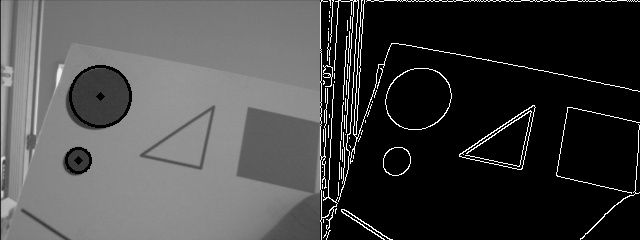

0.0381870269775


In [21]:
for i in range(100):
    
    clear_output(wait=True)    # 清除图片，在同一位置显示，不使用会打印多张图片
    imgMat = cam1.read_img_ori()       # 读入图像
    
    # 缩小图像为320x240尺寸
    origin = cv2.resize(imgMat, (320,240))
    
    # ---------------------  图像处理开始  ----------------------------------------
    start = time.time()        # 记录开始时间
    
    img_gray = cv2.cvtColor(origin, cv2.COLOR_BGR2GRAY)
    img_canny = cv2.Canny(img_gray, 30, 50, apertureSize=3)  # apertureSize是sobel算子的卷积核大小
    
    circles  = cv2.HoughCircles(img_canny, cv2.HOUGH_GRADIENT, 1, 40, param1=50, param2=35, minRadius=0, maxRadius= 80)
    if circles is None:
        pass
    else:
        circles = np.uint16(np.around(circles))
        for i in circles[0,:]:
                # draw the outer circle
                cv2.circle(img_gray,(i[0],i[1]),i[2],(0,255,0),2)
                # draw the center of the circle
                cv2.circle(img_gray,(i[0],i[1]),2,(0,0,255),3)
    
        
    end = time.time()        # 记录结束时间
    # ---------------------  图像处理结束  ----------------------------------------       
    
    # 把图像拼接在一起显示
    img_combine = np.hstack([img_gray, img_canny])
    ps.CommonFunction.show_img_jupyter(img_combine)# 打印用于差分的两张图片
    
    print(end - start)
    time.sleep(0.1)

## 通用轮廓检测并框出

opencv提供了findContours等函数来完成这些功能

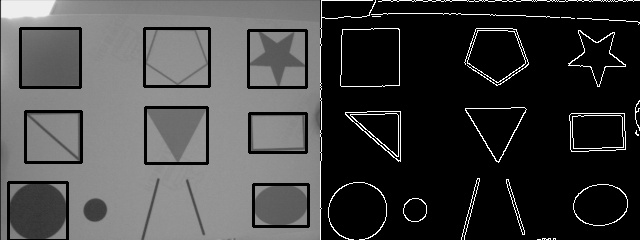

0.00897693634033


In [43]:


for i in range(100):
    
    clear_output(wait=True)    # 清除图片，在同一位置显示，不使用会打印多张图片
    imgMat = cam1.read_img_ori()       # 读入图像
    
    # 缩小图像为320x240尺寸
    origin = cv2.resize(imgMat, (320,240))
    
    # ---------------------  图像处理开始  ----------------------------------------
    start = time.time()        # 记录开始时间
    
    img_gray = cv2.cvtColor(origin, cv2.COLOR_BGR2GRAY)
    img_canny = cv2.Canny(img_gray, 30, 50, apertureSize=3)  # apertureSize是sobel算子的卷积核大小
    
    thresh, contours, hierarchy = cv2.findContours(img_canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours is None:
        pass
    else:
        for cont in contours:
            x, y, w, h = cv2.boundingRect(cont) # 获取外接矩形
            if w < 100 and h < 100 and w > 30 and h > 30:
                cv2.rectangle(img_gray, (x, y), (x + w, y + h), 0, 2)
    
        
    end = time.time()        # 记录结束时间
    # ---------------------  图像处理结束  ----------------------------------------       
    
    # 把图像拼接在一起显示
    img_combine = np.hstack([img_gray, img_canny])
    ps.CommonFunction.show_img_jupyter(img_combine)# 打印用于差分的两张图片
    
    print(end - start)

# 动态图像处理基础

基于视频的车辆检测算法种类很多：光流法检测，帧差法，背景消除法（其中包括：直方图法，平均值法，单分布和混合高斯分布背景模型，Kalman滤波等），边缘检测法，运动矢量检测法...下面分享的是运动目标检测算法中最基本的方法—帧间差分法。

帧间差分法是通过比较两帧之间的像素差来确定运动的物体，是一种常用的运动检测方法。如果物体是运动的，那么在视频中两帧之间其所在位置的像素是不一样的，我们只需要求出两帧之间的像素差，并设定一个阈值，就能轻易地检测出视频中运动的物体。其具体步骤为：

1、读取视频

2、选取两帧 

3、灰度化 

4、滤波 

5、帧间做差

6、二值化

7、形态学操作

**测试方法：** 允许程序后保持相机和背景不动，在摄像头前摇摇手可以看到检测到的手的边缘。

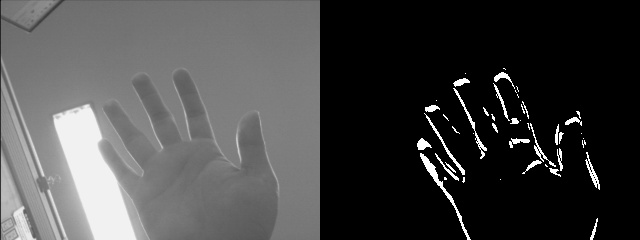

0.00805401802063


In [22]:
def absdiff_demo(backgroundImg, currentImg, Threshold):
    gray_image_1 = cv2.cvtColor(backgroundImg, cv2.COLOR_BGR2GRAY)  #灰度化
    gray_image_1 = cv2.GaussianBlur(gray_image_1, (3, 3), 0)       #高斯滤波
    gray_image_2 = cv2.cvtColor(currentImg, cv2.COLOR_BGR2GRAY)
    gray_image_2 = cv2.GaussianBlur(gray_image_2, (3, 3), 0)
    d_frame = cv2.absdiff(gray_image_1, gray_image_2)
    ret, d_frame = cv2.threshold(d_frame, Threshold, 255, cv2.THRESH_BINARY)
    return d_frame

Threshold = 12 #sThre表示像素阈值
i = 0

# currentImg = np.ones((320,240),dtype=np.uint8)#random.random()方法后面不能加数据类型

for i in range(100):
    
    clear_output(wait=True)    # 清除图片，在同一位置显示，不使用会打印多张图片
    imgMat = cam1.read_img_ori()       # 读入图像
    # 缩小图像为320x240尺寸
    origin = cv2.resize(imgMat, (320,240))
    img_gray = cv2.cvtColor(origin, cv2.COLOR_BGR2GRAY)  #灰度化
    
    # ---------------------  图像处理开始  ----------------------------------------
    start = time.time()        # 记录开始时间
    
    # 第一帧不处理
    if(i==0):
        currentImg = origin
        backgroundImg = currentImg
        diffImg = absdiff_demo(backgroundImg, currentImg, Threshold)
    else:
        backgroundImg = currentImg
        currentImg = origin
        diffImg = absdiff_demo(backgroundImg, currentImg, Threshold)
        
    end = time.time()        # 记录结束时间
    # ---------------------  图像处理结束  ----------------------------------------       
    
    # 把图像拼接在一起显示
    img_combine = np.hstack([img_gray, diffImg])
    ps.CommonFunction.show_img_jupyter(img_combine)# 打印用于差分的两张图片
#     ps.CommonFunction.show_img_jupyter()    # 打印差分图像
    
    print(end - start)
    time.sleep(0.1)